In [7]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

torch.set_printoptions(edgeitems=2, linewidth=75)

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [5]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  5,  6,  9,  3,  8,  4,  0,  2]), tensor([1, 7]))

In [13]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val
t_un_val

tensor([[5.5900],
        [2.1800]])

In [8]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-3.9763],
        [-1.5984]], grad_fn=<AddmmBackward0>)

In [10]:
linear_model.weight

Parameter containing:
tensor([[-0.6973]], requires_grad=True)

In [11]:
linear_model.bias

Parameter containing:
tensor([-0.0782], requires_grad=True)

In [12]:
x = torch.ones(1)
linear_model(x)

tensor([-0.7756], grad_fn=<AddBackward0>)

## Batch Input

In [16]:
x = torch.ones(10, 1)
linear_model(x), linear_model(x).shape

(tensor([[-0.7756],
         [-0.7756],
         [-0.7756],
         [-0.7756],
         [-0.7756],
         [-0.7756],
         [-0.7756],
         [-0.7756],
         [-0.7756],
         [-0.7756]], grad_fn=<AddmmBackward0>),
 torch.Size([10, 1]))

In [18]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr = 1e-2)

In [19]:
linear_model.parameters()

<generator object Module.parameters at 0x0000026B8B535350>

In [20]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5027]], requires_grad=True),
 Parameter containing:
 tensor([-0.2609], requires_grad=True)]

In [65]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
                
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}",
                 f"Validation loss {loss_val.item():.4f}")

In [24]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr = 1e-2)

print(linear_model.weight, linear_model.bias)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight, linear_model.bias)

Parameter containing:
tensor([[-0.2943]], requires_grad=True) Parameter containing:
tensor([-0.2910], requires_grad=True)
Epoch 1, Training loss 260.6004 Validation loss 131.6810
Epoch 1000, Training loss 4.8259 Validation loss 1.1301
Epoch 2000, Training loss 3.0076 Validation loss 2.8431
Epoch 3000, Training loss 2.8571 Validation loss 4.4811

Parameter containing:
tensor([[5.5664]], requires_grad=True) Parameter containing:
tensor([-18.6848], requires_grad=True)


## nn.Sequential

In [25]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [28]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [29]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [31]:
from collections import OrderedDict

In [32]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [33]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [34]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2821], requires_grad=True)

In [66]:
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 1.3212 Validation loss 16.2592
Epoch 1000, Training loss 1.3201 Validation loss 16.3014
Epoch 2000, Training loss 1.3191 Validation loss 16.3439
Epoch 3000, Training loss 1.3180 Validation loss 16.3867
Epoch 4000, Training loss 1.3170 Validation loss 16.4298
Epoch 5000, Training loss 1.3160 Validation loss 16.4731
output tensor([[11.5636],
        [ 1.1972]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [-4.]])
hidden tensor([[ 0.0015],
        [-0.0015],
        [ 0.0016],
        [ 0.0072],
        [ 0.0014],
        [ 0.0011],
        [-0.0048],
        [ 0.0012]])


tensor([[20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.],
        [27.],
        [28.],
        [29.],
        [30.],
        [31.],
        [32.],
        [33.],
        [34.],
        [35.],
        [36.],
        [37.],
        [38.],
        [39.],
        [40.],
        [41.],
        [42.],
        [43.],
        [44.],
        [45.],
        [46.],
        [47.],
        [48.],
        [49.],
        [50.],
        [51.],
        [52.],
        [53.],
        [54.],
        [55.],
        [56.],
        [57.],
        [58.],
        [59.],
        [60.],
        [61.],
        [62.],
        [63.],
        [64.],
        [65.],
        [66.],
        [67.],
        [68.],
        [69.],
        [70.],
        [71.],
        [72.],
        [73.],
        [74.],
        [75.],
        [76.],
        [77.],
        [78.],
        [79.],
        [80.],
        [81.],
        [82.],
        [83.],
        [84.],
        [85.],
        [8

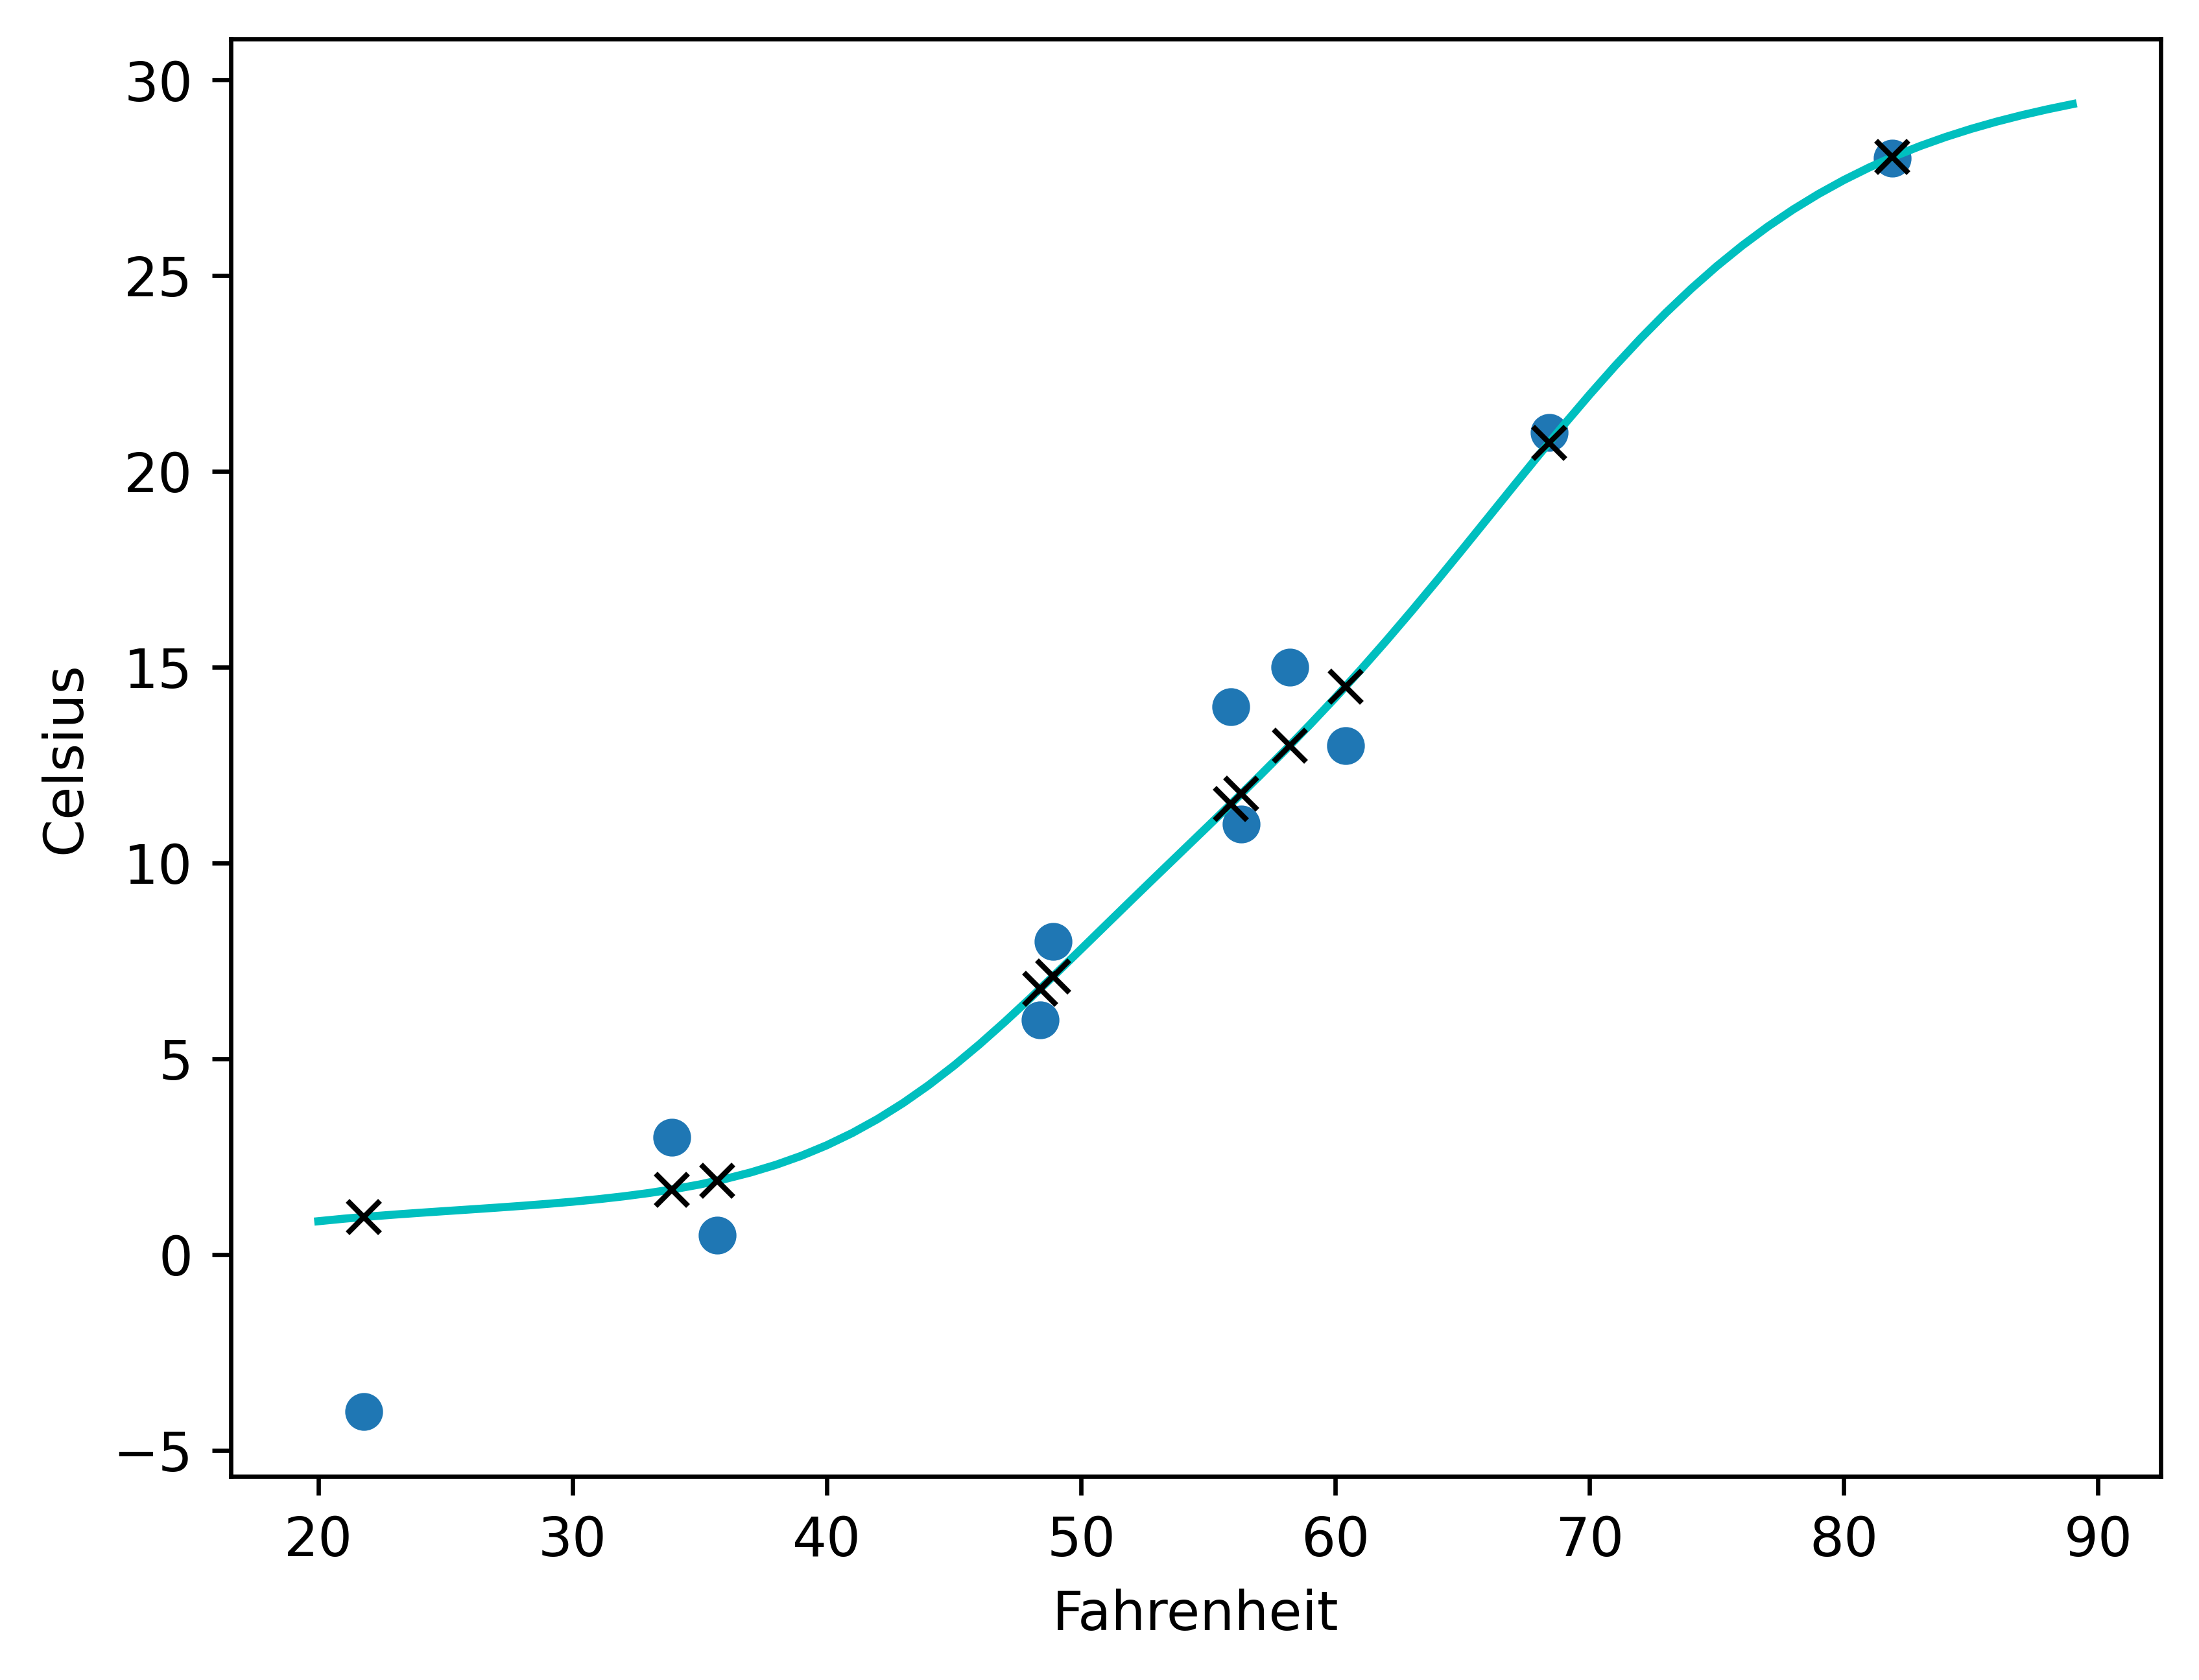

In [41]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

print(t_range, t_range.shape)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')